In [1]:
"""
Attempt to find COMMON principle components across dataset for neuronal firing
Use BAKS firing rate estimates so firing rates are smooth
INSTEAD OF TREATING ALL LATENT DATAPOINTS AS RANDOM VARIABLES, 
ATTEMPT TO FIND RANDOM VARIABLES WHICH ON AVERAGE DESCRIBE THE DATA WELL
"""

'\nAttempt to find COMMON principle components across dataset for neuronal firing\nUse BAKS firing rate estimates so firing rates are smooth\nINSTEAD OF TREATING ALL LATENT DATAPOINTS AS RANDOM VARIABLES, \nATTEMPT TO FIND RANDOM VARIABLES WHICH ON AVERAGE DESCRIBE THE DATA WELL\n'

In [205]:
%matplotlib inline

import pymc3 as pm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import theano.tensor as tt
import os
from sklearn.decomposition import PCA as pca
os.chdir('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from scipy.spatial.distance import cosine as cos_dist

In [3]:
# Firing for which taste to be picked out
taste = 0

In [4]:
# Load dataset 1
data_dir = '/media/bigdata/Abuzar_Data/AS18/AS18_4Tastes_200229_154608'
dat = \
    ephys_data(data_dir)
dat.firing_rate_params = dict(zip(\
    ('type', 'step_size','window_size','dt', 'baks_resolution', 'baks_dt'),
    ('baks',1,250,1,25e-3,1e-3)))

dat.get_unit_descriptors()
dat.get_spikes()
dat.get_firing_rates()
dat1 = dat.normalized_firing[taste]

100%|██████████| 930/930 [00:02<00:00, 400.63it/s]

All tastes have equal dimensions,concatenating and normalizing


In [5]:
# Load dataset 1
data_dir = '/media/bigdata/Abuzar_Data/AS18/AS18_4Tastes_200228_151511/'
dat = \
    ephys_data(data_dir)
dat.firing_rate_params = dict(zip(\
    ('type', 'step_size','window_size','dt', 'baks_resolution', 'baks_dt'),
    ('baks',1,250,1,25e-3,1e-3)))

dat.get_unit_descriptors()
dat.get_spikes()
dat.get_firing_rates()
dat2 = dat.normalized_firing[taste]

100%|██████████| 810/810 [00:02<00:00, 388.66it/s]

All tastes have equal dimensions,concatenating and normalizing


(31, 30, 280)


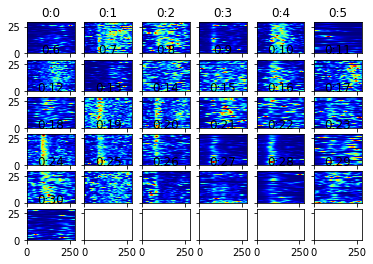

In [6]:
print(dat1.shape)
visualize.firing_overview(dat1);

(27, 30, 280)


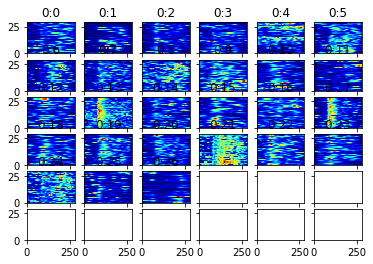

In [7]:
print(dat2.shape)
visualize.firing_overview(dat2);

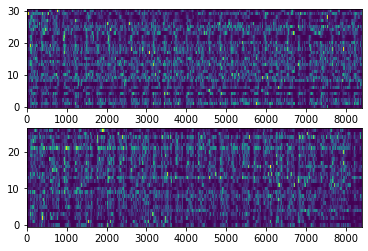

In [8]:
# Different numbers of neurons in each dataset but similar dynamics
# Therefore we should be able to find a single set of PC's which well describe both datasets
dat1_long = np.reshape(dat1, (dat1.shape[0],-1))
dat2_long = np.reshape(dat2, (dat2.shape[0],-1))
fig,ax = plt.subplots(2,1)
plt.sca(ax[0])
visualize.imshow(dat1_long);
plt.sca(ax[1])
visualize.imshow(dat2_long);

In [93]:
# Perform regular PCA for comparison
n_components = 5
pca_object = pca(n_components=n_components)
dat1_pca = pca_object.fit_transform(dat1_long.T)

In [121]:
# Start with prob_pca on single dataset
# References
# https://gist.github.com/twiecki/c95578a6539d2098be2d83575e3d15fe
# http://edwardlib.org/tutorials/probabilistic-pca

# Average latent representation across all trials : pcs x time
# transformation matrix : nrns x pcs
# Data : nrns x trials x time

# D = data dimensionaloty
# K = latent dimensionalty
# N = number of datapoints
# w = transformation matrix, shape ::: D x K
# z = latent data, shape ::: N x K
# x = original data, shape ::: D x N (to facilitate dimensions after multiplication)

x_train = dat1.swapaxes(0,1)
mean_x_train = np.mean(x_train,axis=0)
mean_vals = np.mean(mean_x_train,axis=-1)
mean_sub_x_train = mean_x_train - mean_vals[:,np.newaxis]
sd_vals = np.std(mean_sub_x_train,axis=-1)
scaled_x_train = mean_sub_x_train / sd_vals[:,np.newaxis]
print(scaled_x_train.shape)

D = dat1.shape[0]
K = n_components
N = dat1_long.shape[-1]
trials_num = dat1.shape[1]
nrn_num = dat1.shape[0]
time_num = dat1.shape[-1]

with pm.Model() as PPCA:
    w = pm.Normal('w', mu=tt.zeros([D, K]), sd=2.0 * tt.ones([D, K]), shape=[D, K])
    z = pm.Normal('z', mu=tt.zeros([time_num, K]), sd=tt.ones([time_num, K]), shape=[time_num, K])
    
print(w.tag.test_value.shape)
print(z.tag.test_value.shape)
print(w.dot(z.T).tag.test_value.shape)

(31, 280)
(31, 5)
(280, 5)
(31, 280)


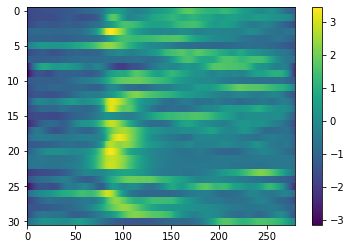

In [122]:
plt.imshow(scaled_x_train,aspect='auto');plt.colorbar()

In [123]:
with PPCA:
    x = pm.Normal('x', mu=w.dot(z.T), sd=tt.ones(scaled_x_train.shape), shape=scaled_x_train.shape, observed=scaled_x_train)  
#     x = pm.Normal('x', mu=tt.tile(w.dot(z.T), trials_num, ndim = 3).reshape(x_train.shape), 
#                   sd=tt.ones(x_train.shape), shape=x_train.shape, observed=x_train)  

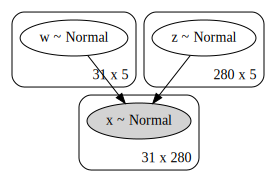

In [124]:
pm.model_to_graphviz(PPCA)

In [125]:
with PPCA:    
    inference = pm.ADVI('full-rank')
    approx = pm.fit(n=40000, method=inference)
    trace = approx.sample(draws=10000)
    #step = pm.Metropolis()
    #trace = pm.sample(step=step)

Average Loss = 10,332: 100%|██████████| 40000/40000 [00:22<00:00, 1783.08it/s]
Finished [100%]: Average Loss = 10,332


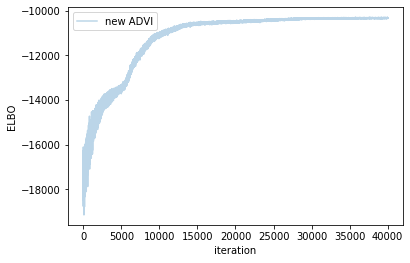

In [126]:
plt.plot(-inference.hist, label='new ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [127]:
w_samples = trace['w']
z_samples = trace['z']
print(w_samples.shape)
print(z_samples.shape)

(10000, 31, 5)
(10000, 280, 5)


In [128]:
mean_z = np.mean(z_samples,axis=0)
mean_w = np.mean(w_samples,axis=0)

In [129]:
# Compare to regular pca
pca_object = pca(n_components=n_components).fit(mean_x_train.T)
pca_x = pca_object.transform(mean_x_train.T)
print(pca_x.shape)

(280, 5)


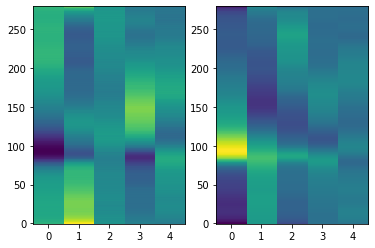

In [130]:
fig,ax = plt.subplots(1,2)
plt.sca(ax[0])
visualize.imshow(mean_z)
plt.sca(ax[1])
visualize.imshow(pca_x)

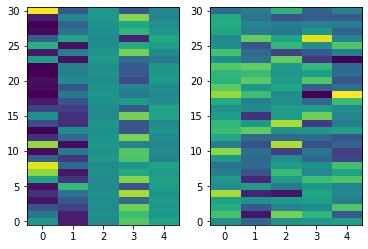

In [131]:
fig,ax = plt.subplots(1,2)
plt.sca(ax[0])
visualize.imshow(mean_w)
plt.sca(ax[1])
visualize.imshow(pca_object.components_.T)

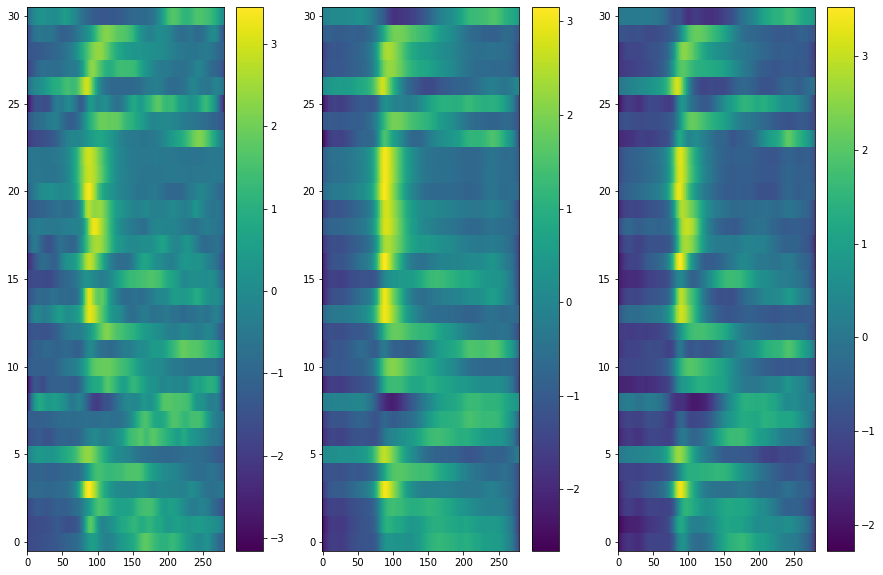

In [132]:
# Check resconstruction visuallize
fig , ax  = plt.subplots(1,3,figsize=(15,10))
plt.sca(ax[0])
visualize.imshow(zscore(mean_x_train,axis=-1))
plt.colorbar()
plt.sca(ax[1])
visualize.imshow(zscore((mean_w.dot(mean_z.T) + mean_vals[:,np.newaxis])*sd_vals[:,np.newaxis],axis=-1))
plt.colorbar()
plt.sca(ax[2])
visualize.imshow(zscore(pca_object.components_.T.dot(pca_x.T) + pca_object.mean_[:,np.newaxis],axis=-1))
plt.colorbar()

In [133]:
##############################################
## JOINT TRANSFORM
##############################################
x_train1 = dat1.swapaxes(0,1)
x_train2 = dat2.swapaxes(0,1)

mean_x_train1 = np.mean(x_train1,axis=0)
mean_x_train2 = np.mean(x_train2,axis=0)
mean_x_train = np.concatenate((mean_x_train1, mean_x_train2),axis=0)
# mean_vals = np.mean(mean_x_train,axis=-1)
# mean_sub_x_train = mean_x_train - mean_vals[:,np.newaxis]
# sd_vals = np.std(mean_sub_x_train,axis=-1)
# scaled_x_train = mean_sub_x_train / sd_vals[:,np.newaxis]
# print(scaled_x_train.shape)

# Just use StandardScaler for test
scaled_x_train = StandardScaler().fit_transform(mean_x_train.T).T
print(scaled_x_train.shape)

D1 = dat1.shape[0]
D2 = dat2.shape[0]
K = n_components
N = dat1_long.shape[-1]
time_num = dat1.shape[-1]

with pm.Model() as PPCA:
    w1 = pm.Normal('w1', mu=tt.zeros([D1, K]), sd=2.0 * tt.ones([D1, K]), shape=[D1, K])
    w2 = pm.Normal('w2', mu=tt.zeros([D2, K]), sd=2.0 * tt.ones([D2, K]), shape=[D2, K])
    z = pm.Normal('z', mu=tt.zeros([time_num, K]), sd=tt.ones([time_num, K]), shape=[time_num, K])
    
print(w1.tag.test_value.shape)
print(w2.tag.test_value.shape)
print(z.tag.test_value.shape)
print(w.dot(z.T).tag.test_value.shape)

(58, 280)
(31, 5)
(27, 5)
(280, 5)
(31, 280)


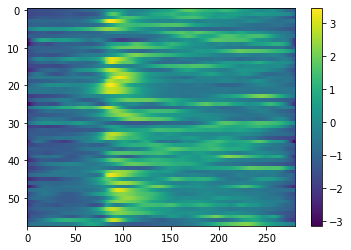

In [134]:
plt.imshow(scaled_x_train,aspect='auto');plt.colorbar()

In [135]:
with PPCA:
    w_fin = tt.concatenate((w1, w2),axis=0)
    x = pm.Normal('x', mu=w_fin.dot(z.T), sd=tt.ones(scaled_x_train.shape), 
                  shape=scaled_x_train.shape, observed=scaled_x_train) 

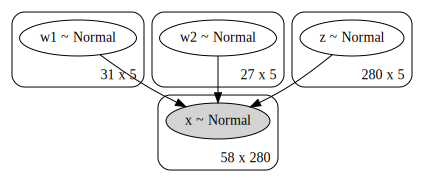

In [136]:
pm.model_to_graphviz(PPCA)

In [137]:
with PPCA:    
    inference = pm.ADVI('full-rank')
    approx = pm.fit(n=40000, method=inference)
    trace2 = approx.sample(draws=10000)

Average Loss = 18,409: 100%|██████████| 40000/40000 [00:27<00:00, 1469.21it/s]
Finished [100%]: Average Loss = 18,409


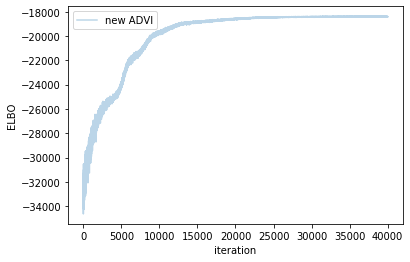

In [143]:
plt.plot(-inference.hist, label='new ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [138]:
w1_samples = trace2['w1']
w2_samples = trace2['w2']
z_samples = trace2['z']
print(w_samples.shape)
print(z_samples.shape)

(10000, 31, 5)
(10000, 280, 5)


In [139]:
mean_z = np.mean(z_samples,axis=0)
mean_w1 = np.mean(w1_samples,axis=0)
mean_w2 = np.mean(w2_samples,axis=0)

In [ ]:
cos_dist(mean_z[0])

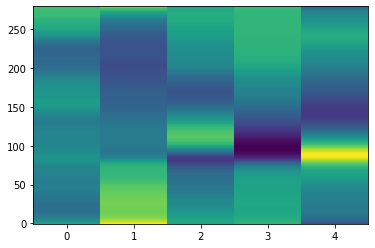

In [140]:
visualize.imshow(mean_z)

[[0.         0.9840218  0.93164753 0.99423402 1.01371731]
 [0.9840218  0.         0.94051335 0.80848451 0.94699045]
 [0.93164753 0.94051335 0.         0.99025929 1.10537367]
 [0.99423402 0.80848451 0.99025929 0.         1.21176966]
 [1.01371731 0.94699045 1.10537367 1.21176966 0.        ]]


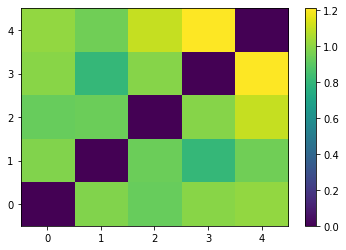

In [156]:
# Check orthogonality of principal components
dist_mat = np.array([[cos_dist(x,y) for x in mean_z.T] for y in mean_z.T])
visualize.imshow(dist_mat)
plt.colorbar()
print(dist_mat)

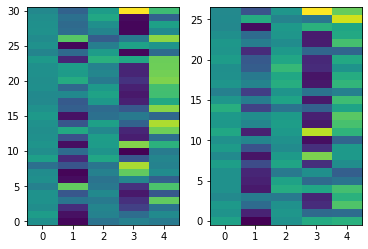

In [141]:
fig,ax = plt.subplots(1,2)
plt.sca(ax[0])
visualize.imshow(mean_w1)
plt.sca(ax[1])
visualize.imshow(mean_w2)

[23 35 42 57 11 39  7 30  8 55 31 25  6 15  0  4 37 52 32 47 36  9 12 29
 10 41 24 50  2 28 17 49 46 51 18 54 38 48 43 40 27  1 56 33 53 16 13 44
 21 14 20  3 22 19 34  5 45 26]


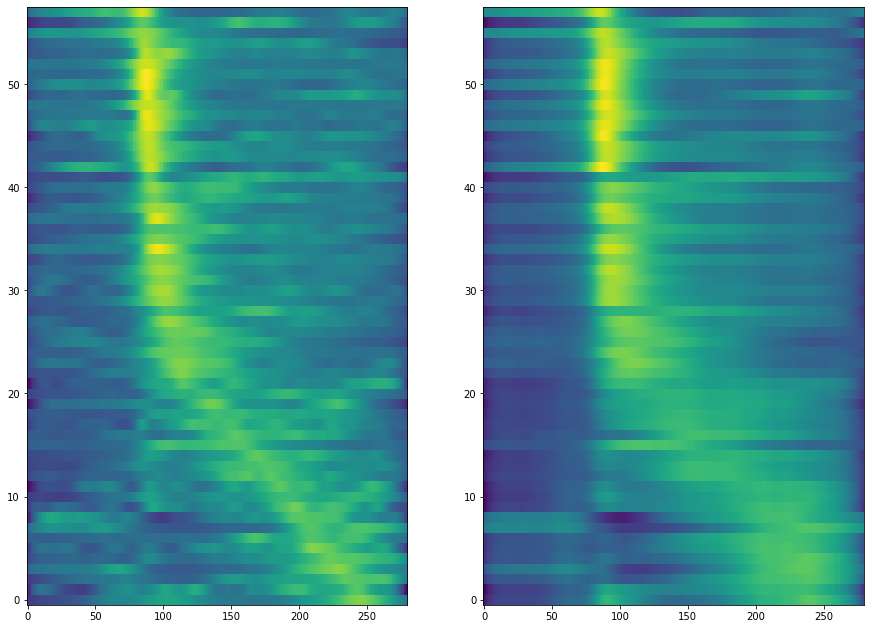

In [142]:
# Check resconstruction visuallize
zscore_mean = zscore(mean_x_train,axis=-1)
zscore_reconstructed = zscore(np.vstack((mean_w1.dot(mean_z.T),mean_w2.dot(mean_z.T))),axis=-1)

sort_inds = np.flip(np.argsort(np.argmax(zscore_mean, axis=-1)))
print(sort_inds)
sort_z_mean = zscore_mean[sort_inds]
sort_z_recon = zscore_reconstructed[sort_inds]

fig , ax  = plt.subplots(1,2, figsize = (15,11))
plt.sca(ax[0])
visualize.imshow(sort_z_mean)
plt.sca(ax[1])
visualize.imshow(sort_z_recon)
# plt.sca(ax[2])
# visualize.imshow(pca_object.components_.T.dot(pca_x.T) + pca_object.mean_[:,np.newaxis])
# plt.colorbar()

(58, 280)
(280, 7)


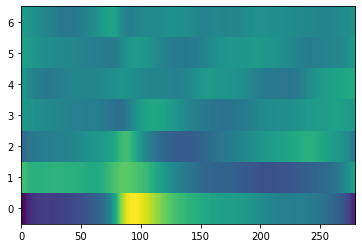

In [209]:
# For fun, reduce joint mean population by PCA and plot in 3D
print(scaled_x_train.shape)
time_lims = [0,scaled_x_train.shape[1]]
cropped_x_train = scaled_x_train[:,time_lims[0]:time_lims[1]]
pca_object = pca(n_components=7).fit(cropped_x_train.T)
pca_x = pca_object.transform(cropped_x_train.T)
print(pca_x.shape)
visualize.imshow(pca_x.T)

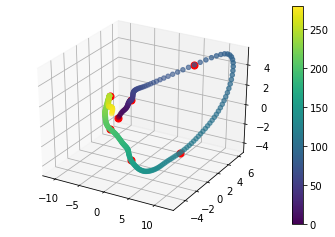

In [216]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# cmap = matplotlib.cm.get_cmap('jet')
# cols = cmap(np.arange(pca_x.shape[0]))
# norm = matplotlib.colors.Normalize(vmin=0, vmax=pca_x.shape[0])
# rgba_color = matplotlib.cm.jet(norm(np.arange(pca_x.shape[0])),bytes=True) 
# print(rgba_color.shape)
secs = np.arange(pca_x.shape[0]//40)*40
im = ax.scatter(pca_x[:,0],pca_x[:,1],pca_x[:,2],c=np.arange(pca_x.shape[0]));
for sec in secs:
    ax.scatter(pca_x[sec,0],pca_x[sec,1],pca_x[sec,2], c='red', s=50)
plt.colorbar(im, ax = ax);